This notebook includes the following topics.
## 1. Data and Data Processing
### - Missing Values
### - Outliers
## 2. Exploratory Data Analysis
## 3. Retention Analysis - Creating New Features
## 4. Retention Analysis by Demographics
## 5. Hypothesis Testing
### - ANOVA
### - Assumption Checks
### - Kruskal-Wallis Test
### - Post-Hoc Tests - Tukey's HSD vs Dunn's Test
## 6. Conclusions And Recommendations

It can also be read from the following link
https://medium.com/@itk48/analyzing-player-retention-and-engagement-using-data-analysis-f41001eb2ca4


## 1. Data and Data Processing
Step 1: Environment Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

I use Google Collab for data analysis. If you don't prefer to do so, ensure that the dataset_path is correct.

In [2]:

from google.colab import drive
drive.mount('/content/drive')
dataset_path = '/content/drive/My Drive/Powerwash Simulator Dataset/data/demographics.csv'
df = pd.read_csv(dataset_path)

Mounted at /content/drive


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11080 entries, 0 to 11079
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pid             11080 non-null  object 
 1   responses       10042 non-null  float64
 2   logins          11080 non-null  int64  
 3   first_login     11080 non-null  object 
 4   last_login      8248 non-null   object 
 5   country         10670 non-null  object 
 6   age             10964 non-null  float64
 7   gender          11018 non-null  object 
 8   n_demographics  11080 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 779.2+ KB


In this dataset, pid indicates a unique identifier for each player, and responses indicate responses to 6 psychological survey questionnaires via in-game pop-ups, explained in reference 2. Other column names are self-explanatory. I want to further examine n_demographics to understand the data.

In [4]:
print("Unique values in 'n_demographics':")
print(df['n_demographics'].unique())

Unique values in 'n_demographics':
[ 1  2  3  7  6  4 16]


In [5]:
print("\nValue counts for 'n_demographics':")
print(df['n_demographics'].value_counts())


Value counts for 'n_demographics':
n_demographics
1     10833
2       232
3         8
7         3
4         2
6         1
16        1
Name: count, dtype: int64


While n_demographics has 7 unique values, it has only 1 "16" value, and almost % 97 of the data is "1". I believe I have nothing to do with this variable, so I extract this feature from the dataset.

In [6]:
df.drop(columns=['n_demographics'], inplace=True)

To quickly see if the DataFrame object has the right data types, and have an overview, we run

In [7]:
df.head(5)

,pid,responses,logins,first_login,last_login,country,age,gender
0,p1,77.0,24,2022-08-18 22:53:05,2023-01-31 23:16:34,USA,22.0,Male
1,p10,340.0,16,2023-02-18 03:02:03,2023-03-04 12:33:53,Czech Republic,28.0,Female
2,p100,1.0,1,2022-09-07 16:06:20,NaN,UK,20.0,Transgender
3,p1000,1.0,1,2022-08-23 14:43:12,NaN,USA,18.0,Female
4,p10000,7.0,2,2022-09-03 23:50:01,2022-09-16 23:31:56,USA,44.0,Female


To obtain a summary of descriptive statistics to understand the central tendency and shape of the distribution, we run

In [8]:
df.describe()

,responses,logins,age
count,10042.000000,11080.000000,10964.000000
mean,72.025991,10.198917,28.251186
std,103.816652,16.006891,8.813566
min,1.000000,1.000000,18.000000
25%,8.000000,1.000000,21.000000
50%,44.000000,5.000000,27.000000
75%,82.000000,12.000000,33.000000
max,3140.000000,274.000000,118.000000


The max value for responses (3140) and logins (274) are significantly higher than the median, suggesting a skewed distribution and indicating potential outliers. Especially from logins, the difference between the median (5) and the maximum value (274), we can understand that a group of players is highly engaged with the game, suggesting further analysis. Also, The median age is 27, and the age value of 118 is quite absurd, especially in this context. It may need further analysis.

### 1.1 Handling Missing Values
Age and responses are continuous variables with skewed distribution. Replacing missing values with the median sounds reasonable. In this case, it minimizes the effect of extreme values, and it is less sensitive to skewed distributions compared to using the mean.

Age and responses are continuous variables with skewed distribution. Replacing missing values with the median sounds reasonable. In this case, it minimizes the effect of extreme values, and it is less sensitive to skewed distributions compared to using the mean.

In [9]:
df['age'] = df['age'].fillna(df['age'].median())
df['responses'] = df['responses'].fillna(df['responses'].median())

Since gender and country are categorical variables, filling missing values with the mode sounds reasonable, as it maintains the most common characteristics in the data.

In [10]:
df['country'] = df['country'].fillna(df['country'].mode()[0])
df['gender'] = df['gender'].fillna(df['gender'].mode()[0])

Filling the missing values for last_login is tricky. See the head of the dataset in image 1, there are some cases in which the player logs in only once, and last_login is missing. For those cases, we assign the first_login value as the last_login value. For the remaining, we group the players by login value. if calculate the median for each group and add it to the first_login value.

In [11]:
df['first_login'] = pd.to_datetime(df['first_login'], errors='coerce')
df['last_login'] = pd.to_datetime(df['last_login'], errors='coerce')

# Calculate the median time difference for each login count group
median_deltas = df.dropna(subset=['last_login']).groupby('logins').apply(lambda x: (x['last_login'] - x['first_login']).median())

def impute_last_login(row):
    if pd.isna(row['last_login']):
        # If logins is 1, set last_login equal to first_login
        if row['logins'] == 1:
            return row['first_login']
        median_delta = median_deltas.get(row['logins'], pd.Timedelta(days=0))
        return row['first_login'] + median_delta
    return row['last_login']

# Apply the imputation function
df['last_login'] = df.apply(impute_last_login, axis=1)

<ipython-input-11-5bfec5493de7>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  median_deltas = df.dropna(subset=['last_login']).groupby('logins').apply(lambda x: (x['last_login'] - x['first_login']).median())


### 1.2 Handling Outliers

From descriptive statistics, we know that responses, age, and login have skewed distributions, and contain potential outliers. One of the best ways to analyze it is to draw a box plot.

### Responses

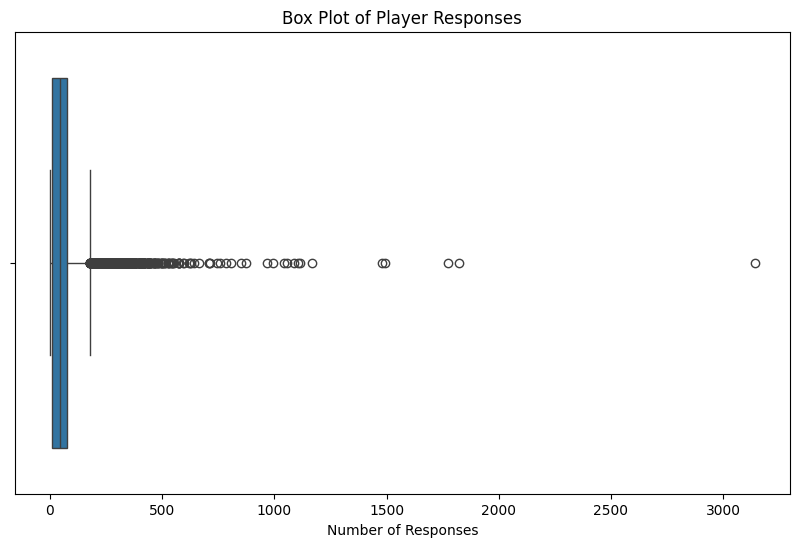

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['responses'])
plt.title('Box Plot of Player Responses')
plt.xlabel('Number of Responses')
plt.show()

Most players seem to have a relatively low number of responses, there are many outliers on the right side of the maximum line, with some players having responses exceeding 500, 1000, and even up to 3000. The majority of the data is clustered on the left, indicating that the distribution is heavily right-skewed. These extreme values are significantly beyond the typical range of responses, which suggests they are statistical outliers. Let's cap them with the 95th percentile

In [13]:
percentile_95 = df['responses'].quantile(0.95)
df['responses'] = np.where(df['responses'] > percentile_95, percentile_95, df['responses'])

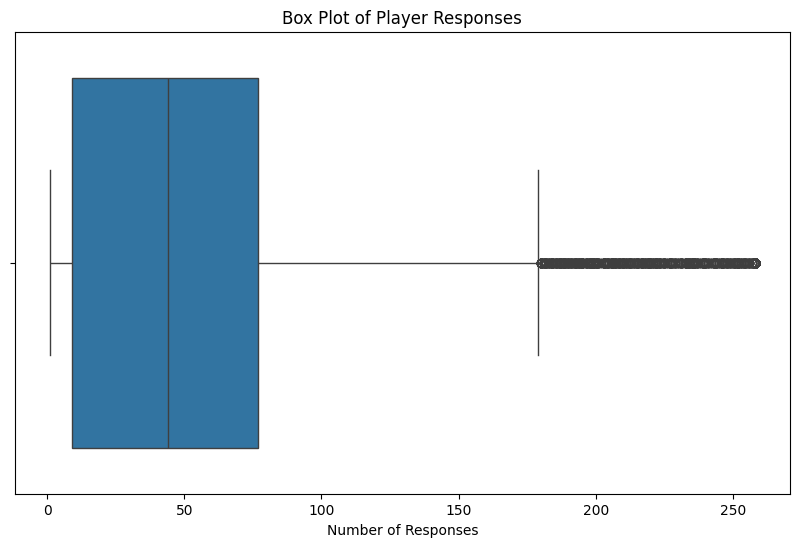

In [14]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['responses'])
plt.title('Box Plot of Player Responses')
plt.xlabel('Number of Responses')
plt.show()

#### Logins

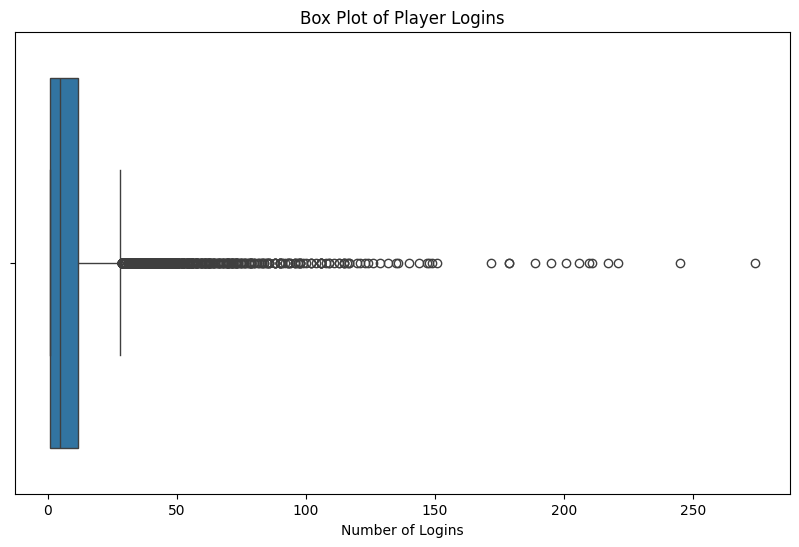

In [15]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['logins'])
plt.title('Box Plot of Player Logins')
plt.xlabel('Number of Logins')
plt.show()

In [16]:
percentile_95_logins = df['logins'].quantile(0.95)
df['logins'] = np.where(df['logins'] > percentile_95_logins, percentile_95_logins, df['logins'])

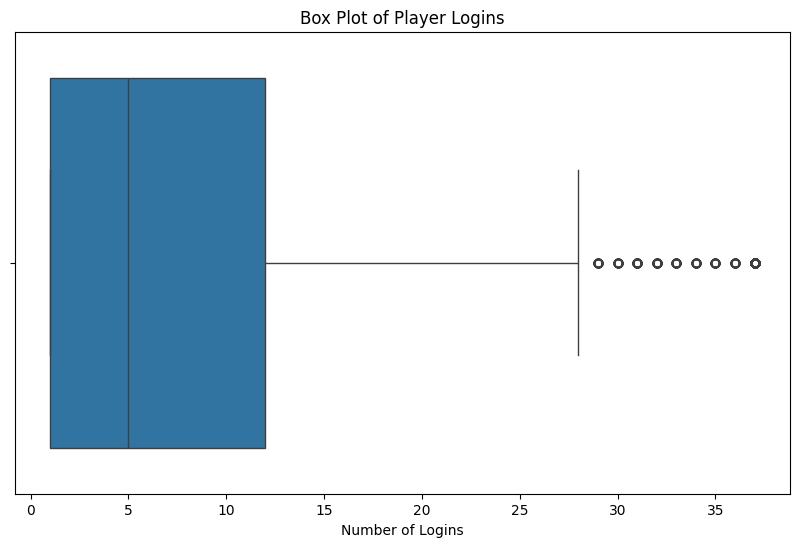

In [17]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['logins'])
plt.title('Box Plot of Player Logins')
plt.xlabel('Number of Logins')
plt.show()

#### Age

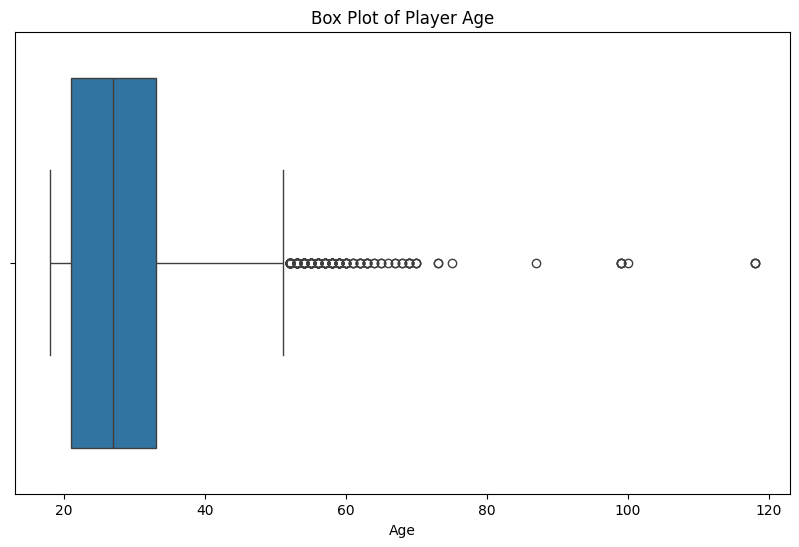

In [18]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['age'])
plt.title('Box Plot of Player Age')
plt.xlabel('Age')
plt.show()

While most players seem to fall between 18 and 40 years old, a very far outlier of 118 exists as an age value. This shall be a misspelling of 18 to 118, or maybe a troll. For other cases, such as 60–100, I believe it is also absurd.
Capping them with the 95th percentile would range the values up to 40,45 which sounds reasonable for the context.

In [19]:
percentile_95_age = df['age'].quantile(0.95)
df['age'] = np.where(df['age'] > percentile_95_age, percentile_95_age, df['age'])

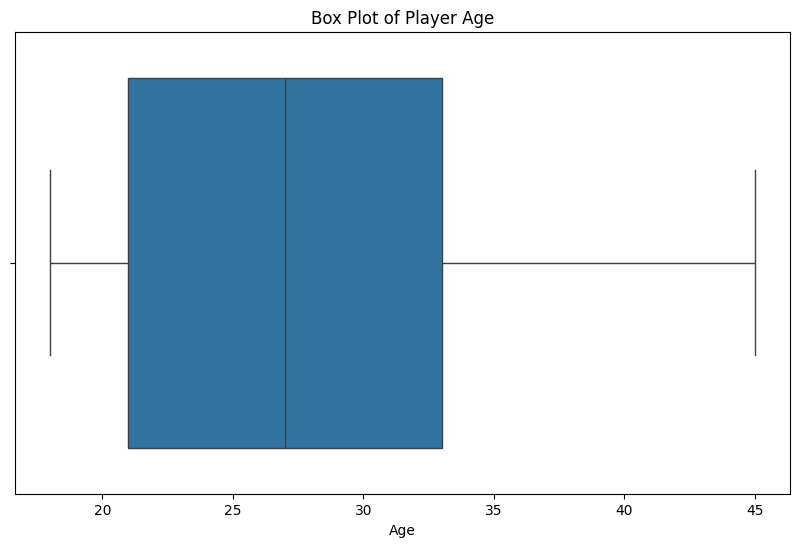

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['age'])
plt.title('Box Plot of Player Age')
plt.xlabel('Age')
plt.show()

As we are done with preprocessing, let us see the descriptive statistics once more.

In [21]:
df.describe()

,responses,logins,first_login,last_login,age
count,11080.000000,11080.00000,11080,11080,11080.000000
mean,63.981859,8.93935,2022-10-16 01:17:00.658032384,2022-12-07 21:31:46.879422208,27.907942
min,1.000000,1.00000,2022-08-18 13:06:56,2022-08-18 13:08:05,18.000000
25%,9.000000,1.00000,2022-08-20 07:35:27,2022-09-05 16:01:02.500000,21.000000
50%,44.000000,5.00000,2022-08-27 04:09:12,2023-01-29 23:30:08.500000,27.000000
75%,77.000000,12.00000,2023-01-31 22:56:04.750000128,2023-02-11 18:09:57,33.000000
max,258.000000,37.00000,2023-03-28 15:54:12,2023-03-31 06:23:01,45.000000
std,71.165663,10.20683,NaN,NaN,7.723164


## 2. Exploratory Data Analysis

### Plot distributions for key metrics
Before we delve deeper into extracting retention from this data, we should dig some more into the data.

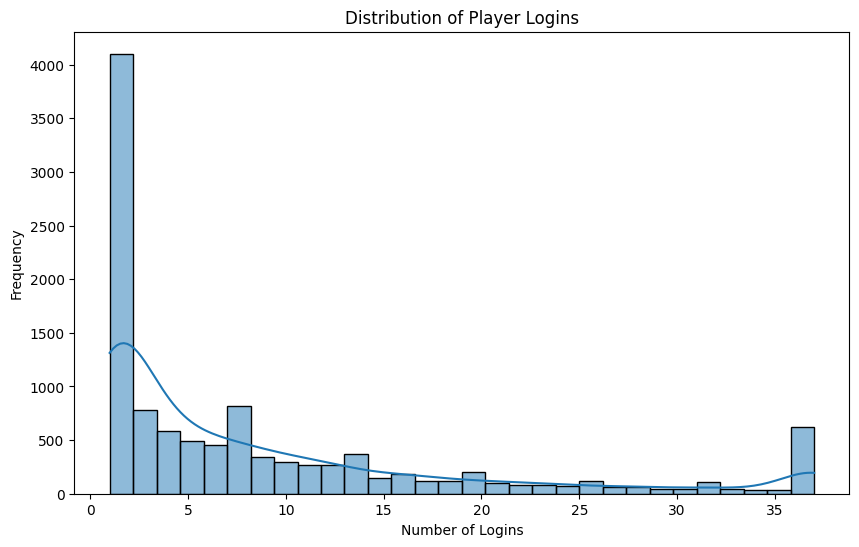

In [22]:
plt.figure(figsize=(10, 6))
sns.histplot(df['logins'], kde=True, bins=30)
plt.title('Distribution of Player Logins')
plt.xlabel('Number of Logins')
plt.ylabel('Frequency')
plt.show()

The distribution is heavily right-skewed, indicating that most players log in only a few times, while fewer players log in many times. Actually, many of the players play the game only once.
There is a long tail extending towards the right, with logins going as high as 35. These high login counts, though rare, indicate a small group of highly engaged players who log in frequently.
Here we can put a clear threshold for the difference in engagement between frequent players and a small number of more engaged players.
This could be useful for segmenting players based on their engagement to define a high-risk churn player vs. an engaged player.

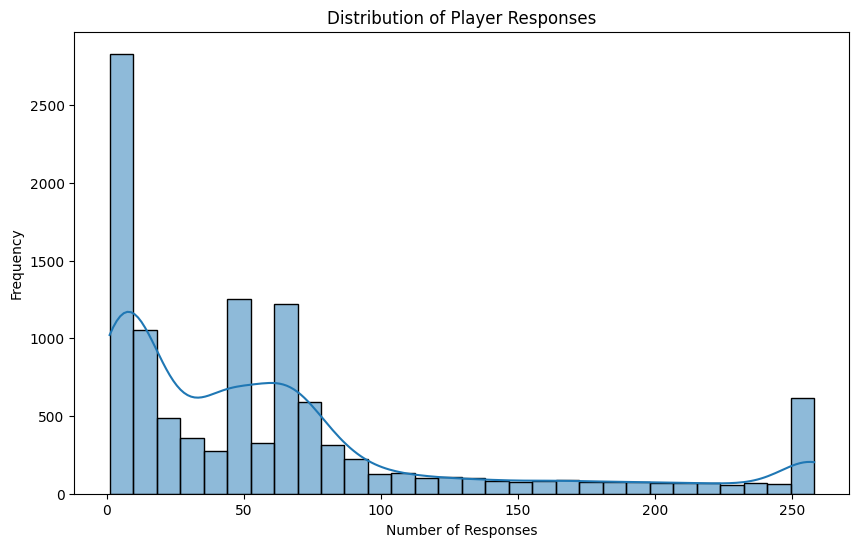

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['responses'], kde=True, bins=30)
plt.title('Distribution of Player Responses')
plt.xlabel('Number of Responses')
plt.ylabel('Frequency')
plt.show()

The distribution of player responses is heavily right-skewed, meaning that most players have relatively low numbers of responses, while a smaller number have very high response counts.
The long tail on the right-hand side of the distribution suggests that some players are extremely engaged, contributing far more responses compared to the average player. The peak in 250 is most likely due to the capping of outliers with the 95th percentile.

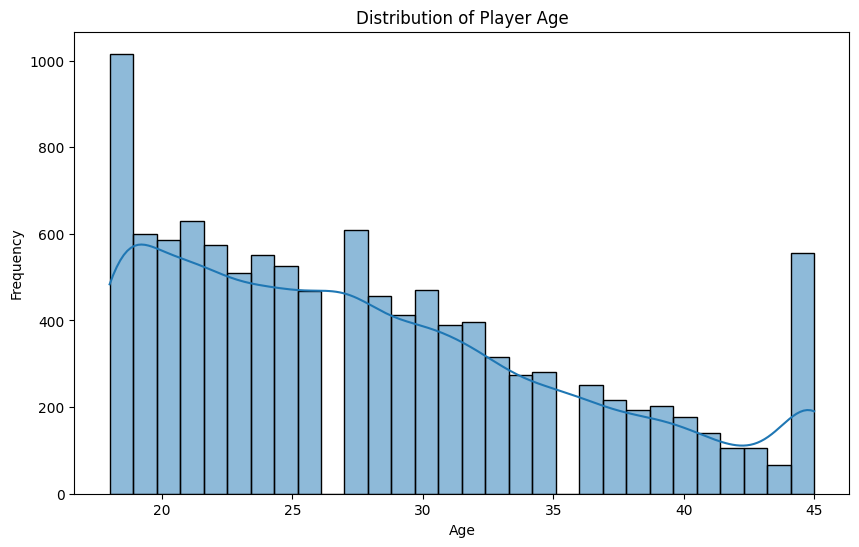

In [24]:
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], kde=True, bins=30)
plt.title('Distribution of Player Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

The distribution shows that the majority of players fall between 18 and 30 years old. The peak occurs around age 20, indicating that younger players form the largest group. The frequency decreases steadily after age 20, which should suggest that the game is most popular among young adults.
There is a slight uptick at age 45, which could be due to the capping of outliers to the 95th percentile. Based on this data, we shall suggest focusing marketing efforts on the 18–30 age group to attract even more players in this demographic.

## 3. RETENTION ANALYSIS

Based on the given data, we could calculate two types of retention
1. Calculate the retention period in days for each player using the first login and the last login
2. Create a retention score using the first login, the last login, and the number of times the player logs in.

In [25]:
# 1st approach: Calculate retention period in days for each player
df['retention_days'] = (df['last_login'] - df['first_login']).dt.days

# 2nd approach: Retention score is calculated using both retention days and number of logins
df['retention_score'] = df['logins'] / (df['retention_days'] + 1)

The retention score measure shows how often a player logs in to the game relative to their retention period.
A higher retention score indicates that a player logged in frequently during their retention period, suggesting higher engagement.
A lower retention score means that even though the player may have been around for a long time, they did not log in frequently.

In [26]:
print(df['retention_days'].describe())

count    11080.000000
mean        52.482130
std         69.661722
min          0.000000
25%          0.000000
50%         11.000000
75%        109.000000
max        224.000000
Name: retention_days, dtype: float64


In [27]:
print(df['retention_score'].describe())

count    11080.000000
mean         0.768154
std          0.791513
min          0.009050
25%          0.146530
50%          0.666667
75%          1.000000
max         12.000000
Name: retention_score, dtype: float64


The mean retention period is 52.48 days, while the median is 11 days.
This significant difference between the mean and median suggests that some players have high retention periods.
The median of 11 days indicates that half of the players were engaged for less than two weeks, suggesting that most players may lose interest relatively quickly.
The minimum retention period is 0 days, which means some players logged in only once and never returned. The maximum is 224 days, indicating that some players remained active over a much longer period - suggesting a small group of highly committed players.
The standard deviation is 69.66 days, which is quite large, indicating a lot of variability in player retention. Some players might have extremely long retention periods, while we know that some players have 0 retention periods.

In [28]:
player_with_max_retention = df[df['retention_days'] == 224]
print(player_with_max_retention[['pid', 'retention_score']])


         pid  retention_score
1402  p11290         0.111111


We can conclude from retention days that the player with 224 days has a high engagement, but its retention score is 0.1111, which has a maximum of 12. I believe combining retention scores and retention days gives a better idea of how players are engaged with the game.

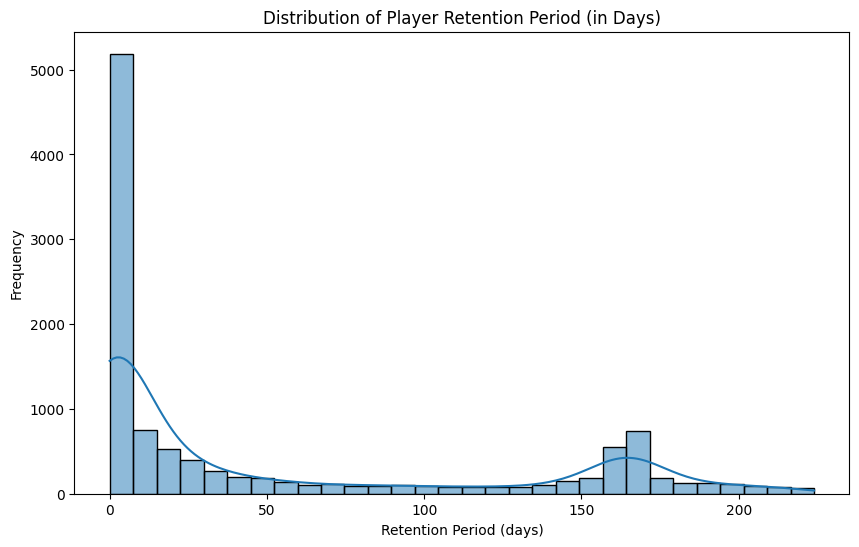

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(df['retention_days'], kde=True, bins=30)
plt.title('Distribution of Player Retention Period (in Days)')
plt.xlabel('Retention Period (days)')
plt.ylabel('Frequency')
plt.show()

The distribution is heavily right-skewed, with a large number of players having a retention period of 0 days. This suggests that many players only logged in once or played for a very short time before stopping entirely.
The long tail extends up to 200+ days, indicating a small number of players are highly engaged and play for extended periods. There is also a minor uptick around 150 days, which could indicate some players coming back at specific times. It could be due to events or content updates.

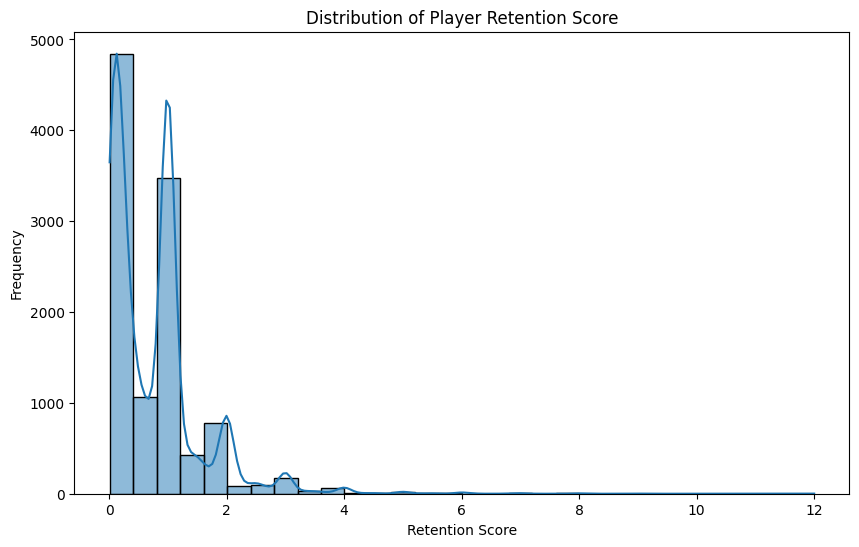

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(df['retention_score'], kde=True, bins=30)
plt.title('Distribution of Player Retention Score')
plt.xlabel('Retention Score')
plt.ylabel('Frequency')
plt.show()

The retention score distribution is highly right-skewed, with the majority of players having low retention scores. This indicates that most players either did not log in frequently or logged in over a short period.
The peak occurs near a retention score of 0, indicating that many players have a very low frequency of logins.
There appear to be multiple small peaks in the distribution. This could suggest different player segments: players with occasional engagement versus those with moderate engagement.

## 4. Retention Analysis by Demographics

In [31]:
age_groups = pd.cut(df['age'], bins=[18, 25, 30, 35, 40, 45], labels=['18-25', '25-30', '30-35', '35-40', '40-45'])
df['age_group'] = age_groups

retention_by_age = df.groupby('age_group')[['retention_days', 'retention_score']].mean()
print(retention_by_age)

           retention_days  retention_score
age_group                                 
18-25           47.513201         0.784340
25-30           52.401076         0.768064
30-35           60.168682         0.723733
35-40           57.668588         0.767846
40-45           66.588115         0.730752


<ipython-input-31-4d6ac64b414f>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  retention_by_age = df.groupby('age_group')[['retention_days', 'retention_score']].mean()


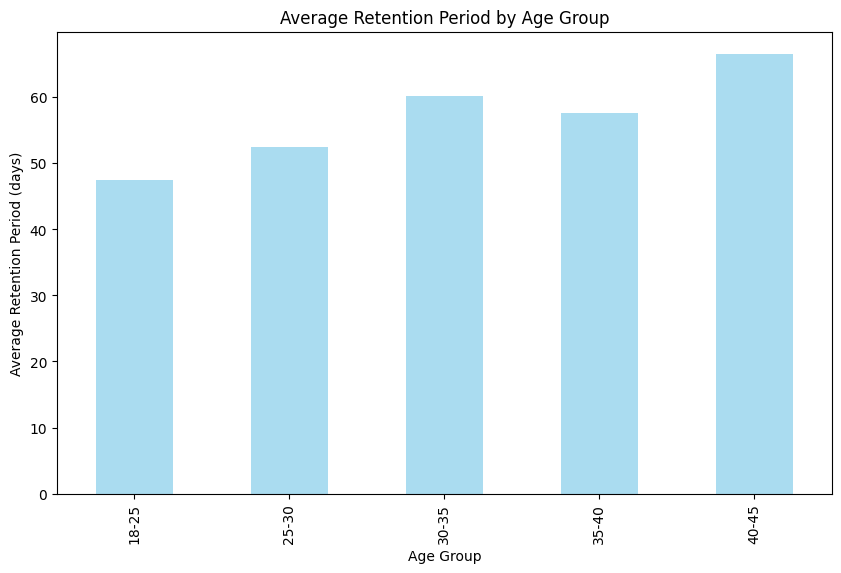

In [32]:
plt.figure(figsize=(10, 6))
retention_by_age['retention_days'].plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Average Retention Period by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Retention Period (days)')
plt.show()

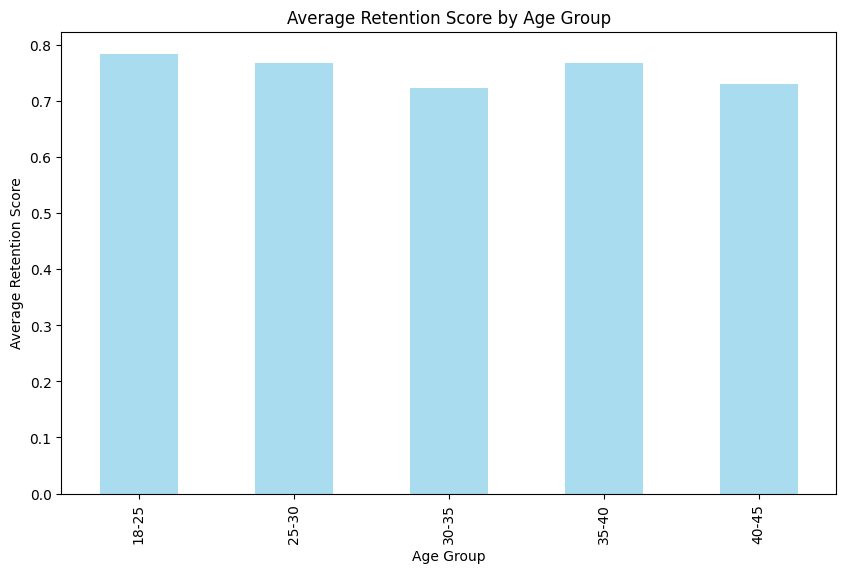

In [33]:
plt.figure(figsize=(10, 6))
retention_by_age['retention_score'].plot(kind='bar', color='skyblue', alpha=0.7)
plt.title('Average Retention Score by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Retention Score')
plt.show()

Solely based on the data from Image 8, we suggested that the distribution shows that the majority of players fall between 18 and 30 years old, i.e. the game is most popular among young adults.
Considering Images 14 and 15, we conclude that the retention period tends to increase as players grow older, peaking in the 40–45 age group. The 18–25 age group shows the lowest retention period but the highest retention score, which might indicate younger players are less committed or may have a higher tendency to switch to other games or activities after binge playing.
The game might be more appealing to older age groups (30 and above). To boost engagement among younger players (18–25), specific marketing efforts or in-game features that appeal more to this demographic could be implemented.

In [34]:
retention_by_gender = df.groupby('gender')[['retention_days', 'retention_score']].mean()
print(retention_by_gender)

                                                   retention_days  \
gender                                                              
Female                                                  63.626959   
Female,Male                                              0.000000   
Female,Male,Non-binary,Transgender                       3.000000   
Female,Male,Transgender                                  1.000000   
Female,Male,Transgender,Other                            2.000000   
Female,Non-binary                                        6.705882   
Female,Non-binary,Other                                 10.000000   
Female,Transgender                                       7.481481   
Female,Transgender,Non-binary                            5.000000   
Intersex                                                77.909091   
Intersex,Female                                         20.000000   
Male                                                    46.255693   
Male,Female                       

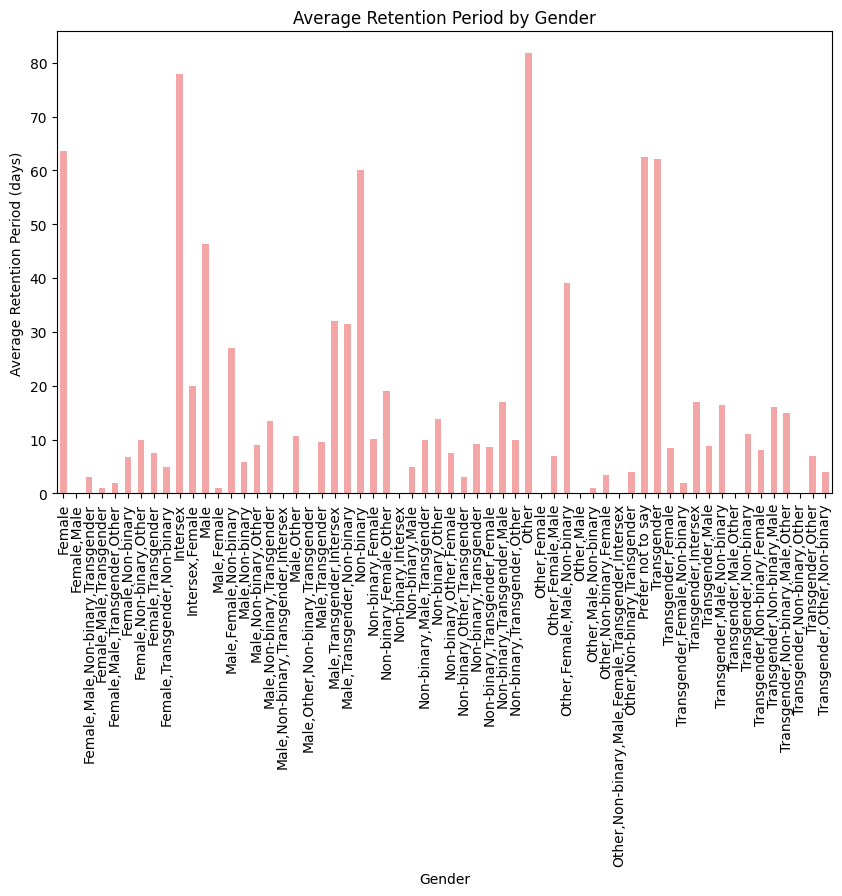

In [35]:
plt.figure(figsize=(10, 6))
retention_by_gender['retention_days'].plot(kind='bar', color='lightcoral', alpha=0.7)
plt.title('Average Retention Period by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Retention Period (days)')
plt.show()

#### By Country

In [36]:
retention_by_country = df.groupby('country')[['retention_days', 'retention_score']].mean().sort_values(by='retention_days', ascending=False).head(10)
print(retention_by_country)



                retention_days  retention_score
country                                        
Israel               74.000000         0.716609
Austria              70.232558         0.536825
Hungary              62.521739         0.716221
Sweden               61.712000         0.735061
Netherlands          60.932292         0.730861
Poland               60.481481         0.741154
Finland              58.083333         0.647056
Ireland              56.704545         0.736197
Czech Republic       56.131579         0.935615
Denmark              55.813187         0.820822


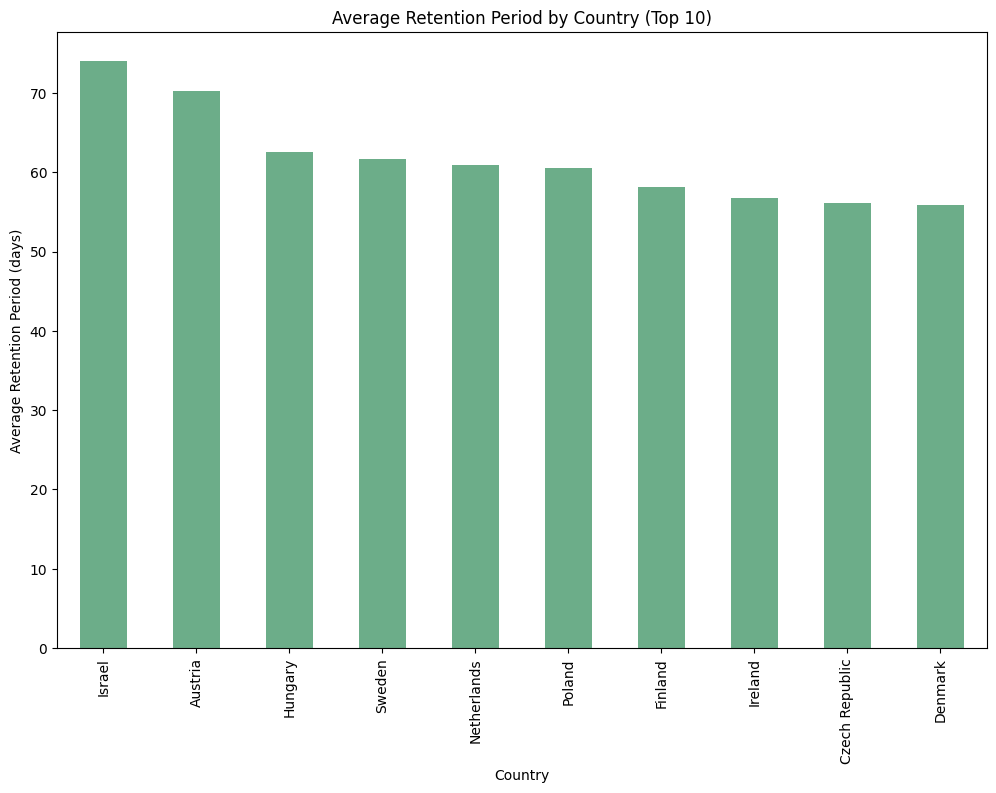

In [37]:
plt.figure(figsize=(12, 8))
retention_by_country['retention_days'].plot(kind='bar', color='seagreen', alpha=0.7)
plt.title('Average Retention Period by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Average Retention Period (days)')
plt.show()

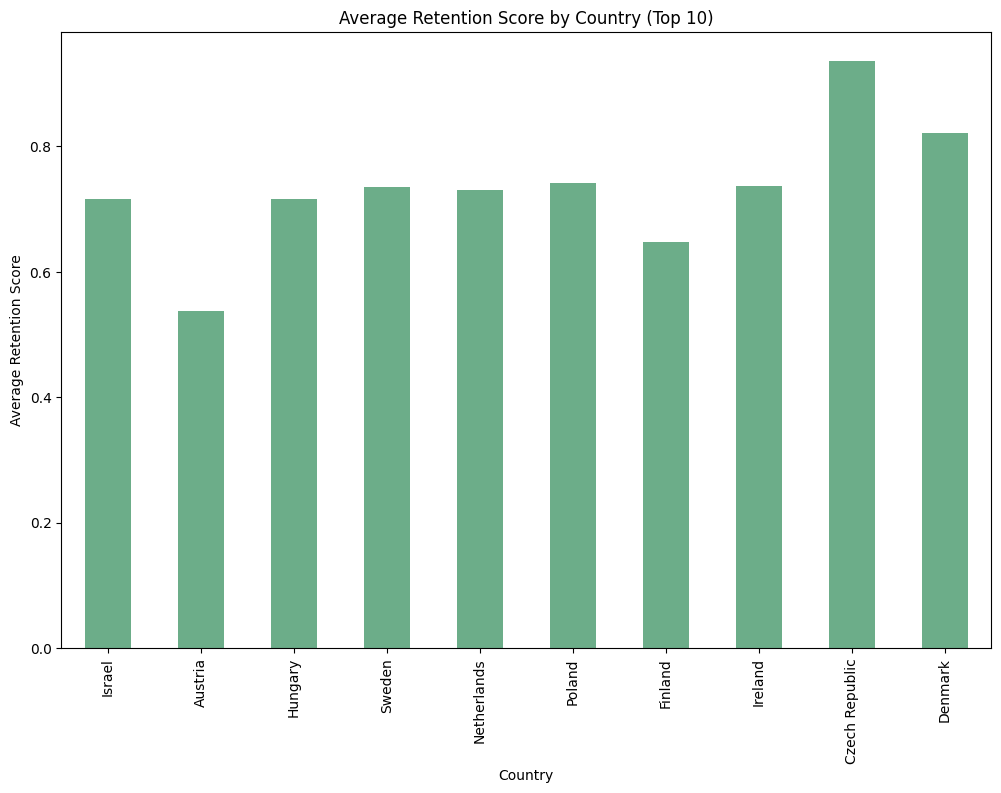

In [38]:
plt.figure(figsize=(12, 8))
retention_by_country['retention_score'].plot(kind='bar', color='seagreen', alpha=0.7)
plt.title('Average Retention Score by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Average Retention Score')
plt.show()

In [39]:
player_count_by_country = df['country'].value_counts().head(10)
print(player_count_by_country)

country
USA            6388
UK             1074
Canada          576
Germany         531
Australia       403
France          292
Netherlands     192
Japan           160
Sweden          125
South Korea     122
Name: count, dtype: int64


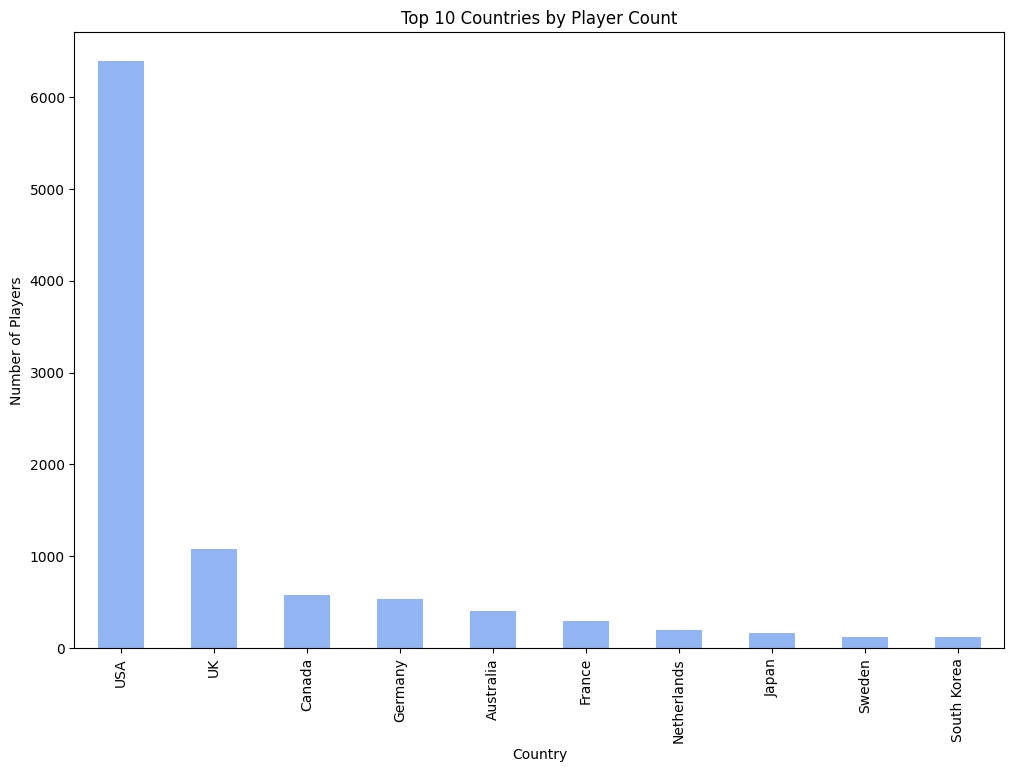

In [40]:
plt.figure(figsize=(12, 8))
player_count_by_country.plot(kind='bar', color='cornflowerblue', alpha=0.7)
plt.title('Top 10 Countries by Player Count')
plt.xlabel('Country')
plt.ylabel('Number of Players')
plt.show()

From Image 13, clearly, the USA has the highest number of players, followed by the UK, and Canada. But from Image 11, 12, we see that Israel has the highest retention period and retention score. This would mean the campaign used in the USA has been successful, or the CPI videos work the best in the USA while players from Israel, Austria, and Hungary are more engaged with the game.

While there is a difference in retention period across different age groups. The graph suggests that some age groups are more engaged than others. To see if this is a statistically significant difference or if it is due to a random variation, let's go for a statistical test.

## 5. Hypothesis Testing - ANOVA (Analysis of Variance) vs. Kruskal-Wallis Test
Before we go for a hypothesis test, let us first put this into perspective:
* Null hypothesis (H₀): There is no significant difference in retention periods between different age groups, meaning that any observed difference could just be noise.
* Alternative hypothesis (H₁): There is a significant difference in retention periods between different age groups.

If the p-value is less than 0.05, we reject the null hypothesis, if it is greater than or equal to 0.05, we fail to reject the null hypothesis, meaning that the observed differences are meaningless.
Since we compare multiple groups, the first test that comes to mind is ANOVA which allows us to compare the means of multiple groups. To apply ANOVA, we first need to check if it satisfies some assumptions;

Assumption Check
* Independence: Each player's data (`first_login`, `last_login`, `logins`) represents a separate, individual event, and these players are not interacting in a way that influences each other's retention. In other words, the data we are working with is player-specific. We gladly agree that independence is satisfied.
* Normality: Since we have a relatively large sample size, taking power from the Central Limit Theorem we would suggest that each group is approximately normally distributed. (Wait for it!!)
* Homogeneity of Variances (Almost! Equal Variances): Visual examination of the box plots suggested that variances across groups were not drastically different, allowing us to assume this requirement was met. (Wait for it!!)

### ANOVA

In [41]:
import scipy.stats as stats

age_group_data = [
    df[df['age_group'] == '18-25']['retention_days'].dropna(),
    df[df['age_group'] == '25-30']['retention_days'].dropna(),
    df[df['age_group'] == '30-35']['retention_days'].dropna(),
    df[df['age_group'] == '35-40']['retention_days'].dropna(),
    df[df['age_group'] == '40-45']['retention_days'].dropna()
]

In [42]:
f_stat, p_value = stats.f_oneway(*age_group_data)
print("ANOVA F-Statistic:", f_stat)
print("ANOVA P-Value:", p_value)

ANOVA F-Statistic: 20.681847739459926
ANOVA P-Value: 5.4070924691962256e-17


### Genuine Assumpiton Checks
#### Normality

In [43]:
from scipy.stats import shapiro

age_groups = df['age_group'].dropna().unique()

for age_group in age_groups:
    retention_data = df[df['age_group'] == age_group]['retention_days'].dropna()
    if len(retention_data) >= 3:  # Yeterli veri noktası olup olmadığını kontrol et
        stat, p_value = shapiro(retention_data)
        print(f"Age Group: {age_group}, Shapiro-Wilk Test P-Value: {p_value}")
        if p_value < 0.05:
            print("  -> Data does not appear to be normally distributed.")
        else:
            print("  -> Data appears to be normally distributed.")
    else:
        print(f"Age Group: {age_group}, Insufficient data for Shapiro-Wilk test (n < 3).")


Age Group: 18-25, Shapiro-Wilk Test P-Value: 6.740440315755131e-64
  -> Data does not appear to be normally distributed.
Age Group: 25-30, Shapiro-Wilk Test P-Value: 2.6269219378838177e-52
  -> Data does not appear to be normally distributed.
Age Group: 40-45, Shapiro-Wilk Test P-Value: 3.574905529805361e-33
  -> Data does not appear to be normally distributed.
Age Group: 30-35, Shapiro-Wilk Test P-Value: 2.805396752554377e-43
  -> Data does not appear to be normally distributed.
Age Group: 35-40, Shapiro-Wilk Test P-Value: 1.936810790834937e-36
  -> Data does not appear to be normally distributed.


So even though a general explanation convinces you that the data is normally distributed, this is not the case. The assumption is clearly violated.

#### Homogenity of Variances

In [44]:
from scipy.stats import levene

age_group_18_25 = df[df['age_group'] == '18-25']['retention_days'].dropna()
age_group_25_30 = df[df['age_group'] == '25-30']['retention_days'].dropna()
age_group_30_35 = df[df['age_group'] == '30-35']['retention_days'].dropna()
age_group_35_40 = df[df['age_group'] == '35-40']['retention_days'].dropna()
age_group_40_45 = df[df['age_group'] == '40-45']['retention_days'].dropna()

stat, p_value = levene(age_group_18_25, age_group_25_30, age_group_30_35, age_group_35_40, age_group_40_45)

print("Levene's Test Statistic:", stat)
print("Levene's Test P-Value:", p_value)


Levene's Test Statistic: 15.370718890023284
Levene's Test P-Value: 1.544767618857263e-12


The homogeneity of variance assumption is also clearly violated. Since two of the assumptions are clearly violated, we cannot expect ANOVA to perform well. While ANOVA compares the mean across different groups, the diverse variation in each group does not allow us to compare the means.
But don't worry, there is a non-parametric way that we can conduct it.

### Kruskal-Wallis

In [45]:
from scipy.stats import kruskal

age_group_data = [
    df[df['age_group'] == '18-25']['retention_days'].dropna(),
    df[df['age_group'] == '25-30']['retention_days'].dropna(),
    df[df['age_group'] == '30-35']['retention_days'].dropna(),
    df[df['age_group'] == '35-40']['retention_days'].dropna(),
    df[df['age_group'] == '40-45']['retention_days'].dropna()
]

h_stat, p_value = kruskal(*age_group_data)
print("Kruskal-Wallis H-Statistic:", h_stat)
print("Kruskal-Wallis P-Value:", p_value)


Kruskal-Wallis H-Statistic: 131.38133953702751
Kruskal-Wallis P-Value: 1.9722850648238523e-27


In [46]:
if p_value < 0.05:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis")

Reject the null hypothesis


So we reject the null hypothesis i.e. there is a significant difference in retention periods between age groups.

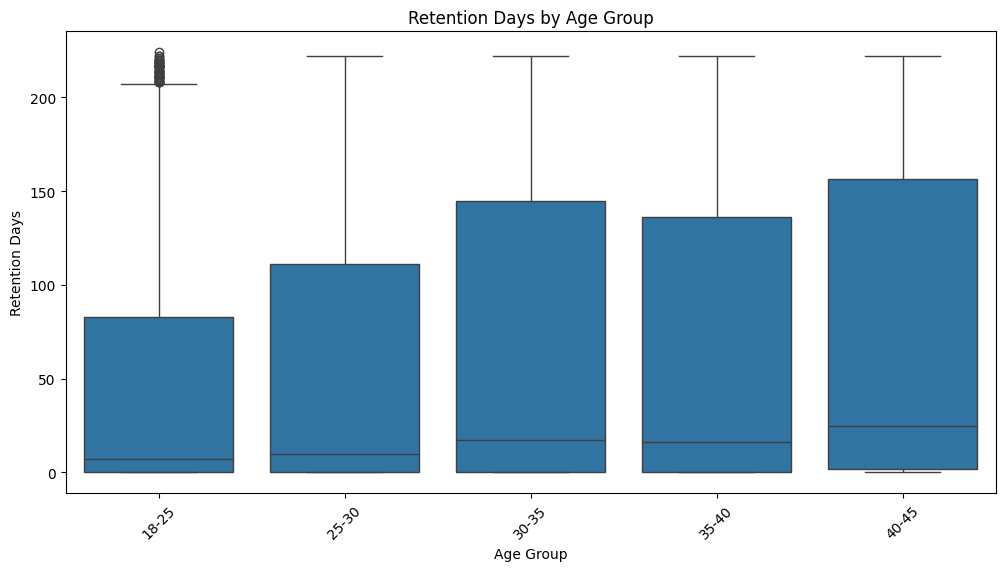

In [47]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='age_group', y='retention_days', data=df)
plt.title('Retention Days by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Retention Days')
plt.xticks(rotation=45)
plt.show()


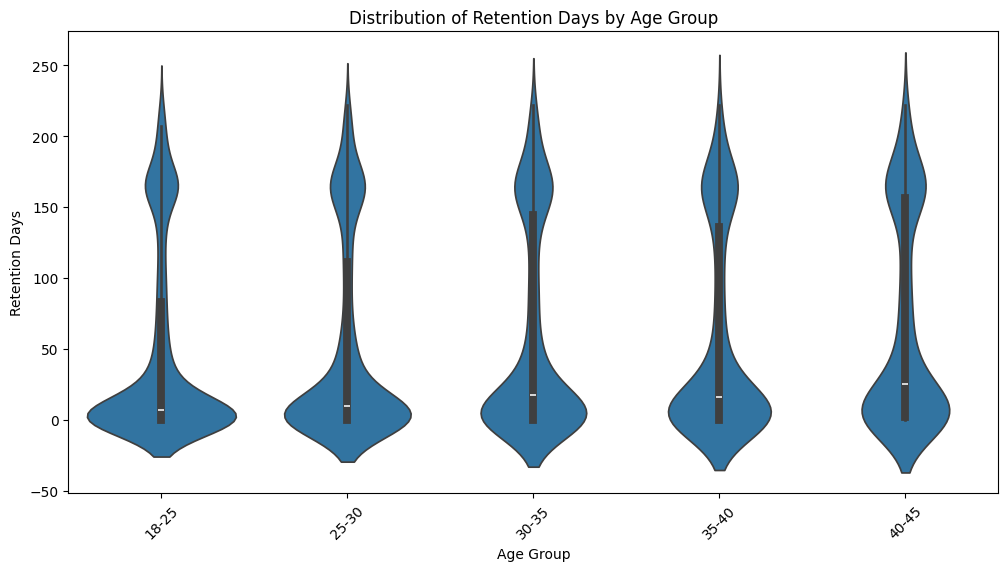

In [48]:
plt.figure(figsize=(12, 6))
sns.violinplot(x='age_group', y='retention_days', data=df)
plt.title('Distribution of Retention Days by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Retention Days')
plt.xticks(rotation=45)
plt.show()

As we see there is clearly a difference between retention periods of age groups, let's further investigate it visually. From Image 16, we conclude that the 40–45 age group shows the highest median retention and also the greatest maximum retention value.
The 18–25 age group has the lowest retention days on average and shows a wider spread with a higher number of outliers. The median retention days increase as we move to older age groups.

### Post-Hoc Test - Dunn's Test


With ANOVA or the Kruskal-Wallis test, based on whether your data satisfies assumptions or not, we understand that there is a significant difference between the age groups. The next step is to understand for which age groups this difference occurs. Post-hoc tests are used for this purpose. If your assumptions were satisfied to conduct ANOVA, you should go for Tukey's HSD. In our case, we conducted a non-parametric test, so as a post-hoc test, we picked Dunn's test.

In [49]:
pip install scikit-posthocs


In [50]:
import scikit_posthocs as sp

dunn_results = sp.posthoc_dunn(age_group_data, p_adjust='bonferroni')

print("Dunn's Test Results:")
print(dunn_results)


Dunn's Test Results:
              1             2             3             4             5
1  1.000000e+00  1.540693e-03  2.331977e-13  2.766074e-08  1.335662e-20
2  1.540693e-03  1.000000e+00  8.247766e-04  3.182397e-02  1.381457e-09
3  2.331977e-13  8.247766e-04  1.000000e+00  1.000000e+00  3.526140e-02
4  2.766074e-08  3.182397e-02  1.000000e+00  1.000000e+00  2.622075e-02
5  1.335662e-20  1.381457e-09  3.526140e-02  2.622075e-02  1.000000e+00


Interpreting the results from Dunn's test, for the p-values less than 0.05, we conclude that variables for corresponding rows/columns have a significant difference.
Group 1 (Ages 18–25) has a significant difference between all the groups, especially 3,4 and 5.
Groups 3 and 4 have no significant difference, meaning they have similar retention in terms of days.
Group 2 and Group 5 have a significant difference.

## 6. Conclusions And Recommendations

* Efforts should be focused on understanding why retention drops so drastically after the initial session (see Image 6) and developing strategies to engage new players longer. The minimum retention period is 0 days, which means some players logged in only once and never returned . This may suggest the game has appealing UI and graphics but may have issues with its mechanics that need urgent investigation.
* Segmenting players into high-risk churn and engaged groups based on their login patterns makes sense (see Image 6). Further investigation could make marketing efforts more effective.
* The game is most popular among the 18–30 age group (Image 8), but their retention period is relatively low for the 18–25 age group as they tend to churn more (see Image 14). New in-game events or strategies are needed to engage younger players.
* Older players have a higher retention period (Image 14), but most players are aged 18–30. Efforts should focus on attracting more older players, as they stay longer.
* Since older players tend to stay longer, this could mean that targeted marketing for these age groups might lead to better In-App Purchase revenue as they have money to spend.
* Since many players are from the USA but have low retention, organizing USA-based events seems like a reasonable approach.
* Countries like Israel, Sweden, and Hungary have high retention rates but a smaller player base. Comparing CPI videos and campaign variables with the USA could help identify and address potential issues.